In [69]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('bmh')

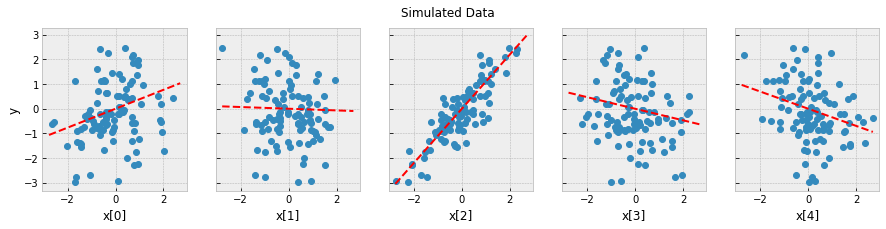

In [70]:
np.random.seed(0)

ndims = 5
ndata = 100
X = np.random.randn(ndata, ndims)
w_ = np.random.randn(ndims)

noise_ = 0.1 * np.random.randn(ndata)
y_obs = X.dot(w_) + noise_


fig, axes = plt.subplots(sharey=True, ncols=ndims, figsize=(15, 3))

t = np.linspace(X.min(), X.max())
for idx, (ax, x) in enumerate(zip(axes.ravel(), X.T)):
    ax.plot(x, y_obs, 'o');
    ax.plot(t, w_[idx] * t, 'r--')
    ax.set_xlabel(f'x[{idx}]')
axes[0].set_ylabel('y')
fig.suptitle('Simulated Data');

## The Model

We have generated a linear regression dataset with 5 dimensions and 100 datapoints. 

In each library, we will define the joint probability distribution

$$
p(\mathbf{w}) \sim \mathcal{N}(\mathbf{0}, I_5)\\
p(\mathbf{y} | X, \mathbf{w}) \sim \mathcal{N}(X\mathbf{w}, 0.1I_{100}),
$$
where $I_5$ is a $5 \times 5$ identity matrix, and $I_{100}$ a $100 \times 100$ identity.

We then provide code to sample 1,000 draws from the posterior distribution: 

$$
p(\mathbf{w} | X, \mathbf{y}) \propto p(\mathbf{y} | X, \mathbf{w}) p(\mathbf{w})
$$

Note that in this case we can just do the math, and the actual posterior is

$$
p(\mathbf{w} | X, \mathbf{y}) = \mathcal{N}((X^TX + I_5)^{-1}X^Ty, (X^TX + I_5)^{-1})
$$



# Hamiltonian Mxnet

In [118]:
import sys
sys.path.append("../") 

In [119]:
import mxnet as mx
from mxnet import nd, autograd, gluon

model_ctx=mx.gpu()
hyper={'alpha':nd.array(1.0, ctx=model_ctx),'scale':0.1}

In [120]:
import importlib
import hamiltonian
importlib.reload(hamiltonian.models.linear)
importlib.reload(hamiltonian.inference.hmc)

<module 'hamiltonian.inference.hmc' from '../hamiltonian/inference/hmc.py'>

In [121]:
from hamiltonian.inference.hmc import hmc
from hamiltonian.models.linear import linear

model=linear(hyper,ctx=model_ctx)

In [122]:
X_train=nd.array(X,ctx=model_ctx)
y_train=nd.array(y_obs,ctx=model_ctx)

In [ ]:
par={'weights':nd.random_normal(shape=ndims,ctx=model_ctx),'bias':nd.random_normal(shape=1,ctx=model_ctx)}
inference=hmc(model,par,step_size=0.1,ctx=model_ctx)
posterior_samples_1,loss_1=inference.fit(epochs=4000,burn_in=1000,
                           path_length=1.0,X_train=X_train,y_train=y_train)

 99%|█████████▉| 4939/5000 [04:03<00:03, 18.19it/s]

In [101]:
posterior_samples_numpy_1=dict()

for var in posterior_samples.keys():
    posterior_samples_numpy_1.update(
        {var:np.expand_dims(np.asarray(
            [sample.asnumpy() for sample in posterior_samples_1[var]]),0)
        })

In [102]:
import arviz as az

dataset1=az.convert_to_inference_data(posterior_samples_numpy_1)

In [103]:
par={'weights':nd.random_normal(shape=ndims,ctx=model_ctx),'bias':nd.random_normal(shape=1,ctx=model_ctx)}
inference=hmc(model,par,step_size=0.1,ctx=model_ctx)
posterior_samples_2,loss_2=inference.fit(epochs=4000,burn_in=1000,
                           path_length=1.0,X_train=X_train,y_train=y_train)

100%|██████████| 5000/5000 [04:08<00:00, 20.14it/s]


In [104]:
posterior_samples_numpy_2=dict()

for var in posterior_samples.keys():
    posterior_samples_numpy_2.update(
        {var:np.expand_dims(np.asarray(
            [sample.asnumpy() for sample in posterior_samples_2[var]]),0)
        })

In [105]:
dataset2=az.convert_to_inference_data(posterior_samples_numpy_2)

In [108]:
dataset = az.concat(dataset1, dataset2, dim="chain")

In [116]:
az.summary(dataset1)

arviz - WARNING - Shape validation failed: input_shape: (1, 3999), minimum_shape: (chains=2, draws=4)


mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
weights[0]  0.374  0.0   0.374    0.374        0.0      0.0    3998.0   
weights[1]  1.185  0.0   1.185    1.185        0.0      0.0    3998.0   
weights[2]  2.058  0.0   2.058    2.058        0.0      0.0    3998.0   
weights[3]  0.183  0.0   0.183    0.183        0.0      0.0    3998.0   
weights[4] -0.839  0.0  -0.839   -0.839        0.0      0.0    3998.0   
bias[0]    -0.744  0.0  -0.744   -0.744        0.0      0.0    3998.0   

            ess_tail  r_hat  
weights[0]    3998.0    NaN  
weights[1]    3998.0    NaN  
weights[2]    3998.0    NaN  
weights[3]    3998.0    NaN  
weights[4]    3998.0    NaN  
bias[0]       3998.0    NaN

In [110]:
dataset

Inference data with groups:
	> posterior

## PyMC3

In [111]:
import pymc3 as pm
import theano.tensor as tt

In [112]:
with pm.Model():
    w = pm.Normal('w', 0, 1, shape=ndims)
    y = pm.Normal('y', tt.dot(X, w), 0.1, observed=y_obs)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [113]:
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
w[0]  0.372  0.010   0.353    0.391        0.0      0.0    6326.0    2805.0   
w[1] -0.035  0.011  -0.056   -0.016        0.0      0.0    7084.0    2877.0   
w[2]  1.094  0.010   1.076    1.114        0.0      0.0    5531.0    3003.0   
w[3] -0.234  0.010  -0.253   -0.216        0.0      0.0    6373.0    3296.0   
w[4] -0.339  0.011  -0.359   -0.319        0.0      0.0    6772.0    3228.0   

      r_hat  
w[0]    1.0  
w[1]    1.0  
w[2]    1.0  
w[3]    1.0  
w[4]    1.0